(array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]]), array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]]), 0)


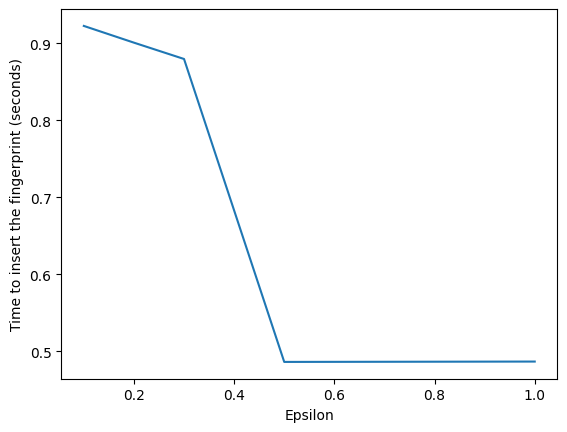

In [5]:
import numpy as np
import hashlib
import time
import secrets
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from joblib import Parallel, delayed

def u(seed):
    hash_value = hashlib.sha256(seed.encode()).digest()
    random_seed = int.from_bytes(hash_value[:4], byteorder='big')
    return secrets.SystemRandom(random_seed).randrange(2**32)

def fingerprint_database(R, epsilon, k, Y, n_jobs):
    n_records = len(R)
    n_attributes = len(R[0])
    P = []
    for i in range(n_records):
        for j in range(n_attributes):
            P.append((i, j))

    IDinternal = Y.encode('utf-8')

    h = hashlib.new('sha256')
    h.update(IDinternal)
    f = h.digest()
    M = R.copy()
    p = 1 / (np.exp(epsilon / k) + 1)
    L = len(f) * 8 
    np.random.seed(0)
    cnt = 0
    
    def fingerprint_database(R, epsilon, k, Y):
    # ...
       M = R.copy() # Create a copy of R to modify
    # ...
       for (i, j) in P:
        s = (Y+(str(M[i,j])+str(i)+str(j)))
        if u(s) % np.floor(1 / (2 * p)) == 0:
            x = u(s) % 2
            l = u(s)% L
            fi = (f[l//8] >> (l%8)) & 1  
            b = x ^ fi
            M[i, j] = int(M[i, j]) ^ b
            cnt+=1
    # ...
    return R,M,cnt

# Load dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
df = pd.read_csv(url, header=None, names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])

# Drop unnecessary column
df = df.drop(['fnlwgt'], axis=1)

# One-hot encode categorical features
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']])

# Run fingerprinting algorithm
result = fingerprint_database(transformed.toarray(), 0.2, 2, secrets.token_hex(32), n_jobs=4)

# Print the results
print(result)

import matplotlib.pyplot as plt

epsilons = [0.1, 0.2, 0.3, 0.5, 1.0]
times = []

for epsilon in epsilons:
    start = time.time()
    _, _, t = fingerprint_database(transformed.toarray(), epsilon, 2, secrets.token_hex(32), n_jobs=4)
    end = time.time()
    times.append(end - start)

plt.plot(epsilons, times)
plt.xlabel('Epsilon')
plt.ylabel('Time to insert the fingerprint (seconds)')
plt.show()
